In [3]:
import pandas as pd 
import numpy as np
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.model_selection
import sklearn.cluster
import matplotlib
from matplotlib import pyplot as plt
import py2neo
#import seaborn as sb ##includes convenient heatmaps and boxplots
import scipy as sp
import pylab as pl
from sklearn.metrics import silhouette_score
from collections import Counter
import time
#from ggplot import *
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist


from sklearn.manifold import TSNE
import matplotlib.cm as cm

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Query Database

In [2]:
def query_database(query):
    # REMEMBER TO BE CONNECTED TO IMPERIAL WIFI!
    graph_db = py2neo.Graph("https://dsi-bitcoin.doc.ic.ac.uk:7473/db/data/", auth=("guest_ro", "imperialO_nly"))
    return graph_db.run(query)

def get_block_data(first_block, last_block):
    query_string = """
                    MATCH (b:Block) <-[:MINED_IN]- (t:Tx) <-[:IN]- (txi:TxIn) <-[:UNLOCK]- (iadr:Address)
                    WHERE b.height >= {} AND b.height <= {}
                    MATCH (txi) <-[:SPENT]- (txo_in:TxOut) 
                    MATCH (oadr:Address) <-[:LOCK]- (txo_out:TxOut) <-[:OUT]- (t)
                    
                    RETURN iadr.address as iadr, oadr.address as oadr, txo_in.value as input_val, txo_out.value as output_val, ID(txo_in) as id_txo_in, ID(txi) as id_txi, ID(t) as id_t, ID(txo_out) as id_txo_out
                    """.format(first_block, last_block)
    return query_string

def write_to_csv(result,string):

    df = result.to_data_frame()

    if (df.empty):
        print("Something went wrong, there is no data for this/these blocks")
    else:
        df.to_csv('{}.csv'.format(string), encoding='utf-8', index=False)


In [4]:
result = query_database(get_block_data(400000,400000))
df = result.to_data_frame()

In [ ]:
#Check if any columns are unique
for column in df:
    print(df[column].is_unique)

In [ ]:
print(df['oadr'].value_counts().sort_values(ascending=False))
df1 = df.loc[df['iadr'] == '1BQLNJtMDKmMZ4PyqVFfRuBNvoGhjigBKF']

In [ ]:
#Counting the number of shared input addresses per transaction

tx_ids = []
    
for val in df.id_t.value_counts().iteritems():
    tx_ids.append(val[0])

def iadrs_from_tx(id_t):
    return list(df['iadr'][df["id_t"] == id_t])


for t in tx_ids:
    dummy = iadrs_from_tx(t)
    print (t)
    break
    

Counter(dummy)
    

In [ ]:
from collections import Counter
Counter(dummy)

In [ ]:
df.head()

# Preprocessing

Explained variation per principal component: [0.46378575 0.27602792 0.12838918 0.1212173  0.01057986]


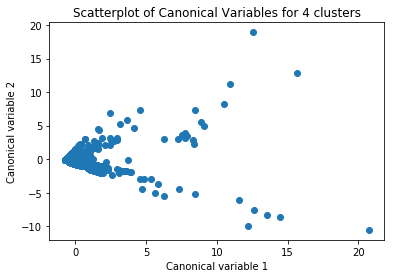

In [6]:
#Feature extraction
cluster = (
    df.groupby('id_t')
    .agg({
        'input_val': 'sum',
        'id_txi': 'nunique',
        'id_txo_out': 'nunique',
        'iadr': 'nunique',
        'oadr': 'nunique',       
    }).rename(columns = {
        'iadr':'num_unique_addr_in',
        'oadr':'num_unique_addr_out',
        'input_val':'total_val'
    })
)

cluster['ratio'] = cluster['id_txi'] / cluster['id_txo_out']
cluster['degree'] = cluster['id_txi'] + cluster['id_txo_out'] 

cluster = cluster.drop(columns=['id_txi', 'id_txo_out'])

#Normalize data

scaler = sklearn.preprocessing.StandardScaler()
scaled_cluster = scaler.fit_transform(cluster)
cluster_scaled = pd.DataFrame(scaled_cluster, columns=cluster.columns, index=cluster.index)

#CHECK RandomizedPCA with whiten=True

#Principal Component Analysis - DIMENSIONALITY REDUCTION
pca = sklearn.decomposition.PCA()
plot_columns = pca.fit_transform(cluster_scaled)   
#cmap = matplotlib.colors.ListedColormap(colors),
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1])
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 clusters')
plt.show

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df_pca = cluster_scaled
df_pca['pca_1'] = plot_columns[:,0]
df_pca['pca_2'] = plot_columns[:,1]
df_pca['pca_3'] = plot_columns[:,1]
df_pca['pca_4'] = plot_columns[:,1]

feat_col=['pca_1', 'pca_2', 'pca_3', 'pca_4']

In [ ]:
# data_corr = cluster_scaled.corr()
# sb.heatmap(data_corr, cmap = 'bwr') #heatmap of correlation matrix

## Clustering - PCA and KMeans combined

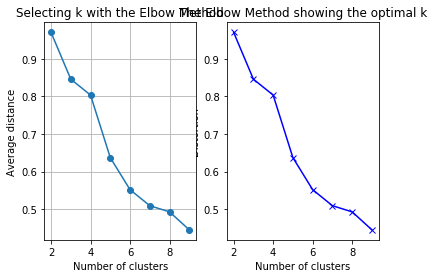

In [22]:
#split data into train and test sets
clus_train, clus_test = sklearn.model_selection.train_test_split(df_pca.loc[:,feat_col], test_size=0.3, random_state=123)

clusters = range(2,10)
meandist=[]
distortions = []
ss = []

for k in clusters:
    model = sklearn.cluster.KMeans(n_clusters = k)
    model.fit(clus_train)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(clus_train,model.cluster_centers_,'euclidean'),axis=1))/clus_train.shape[0])
    #distorsions.append(model.inertia_) 
    distortions.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) / clus_train.shape[0])
    ss.append(silhouette_score(clus_train, model.labels_))

# Plot the elbow
plt.subplot(1, 2, 2)
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.subplot(1, 2, 1)
plt.plot(clusters, meandist, '-o')
plt.title('Selecting k with the Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')

# plt.subplot(1, 2, 2)
# plt.plot(clusters, distorsions, '-o')
# plt.title('Selecting k with the Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Model inertia')

plt.show
plt.grid(True)


Text(0.5,1,'The Elbow Method showing the optimal k')

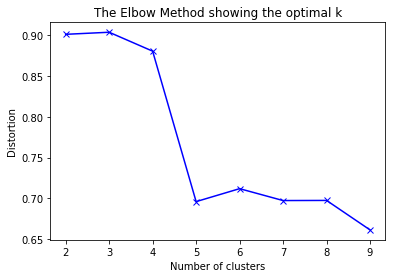

In [23]:
# Plot the elbow
plt.plot(clusters, ss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')


Silhouette Score: 0.903725


<function matplotlib.pyplot.show(*args, **kw)>

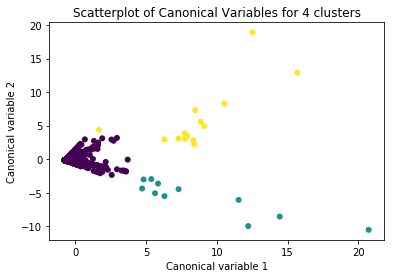

In [24]:
#K means with 4 clusters
model = sklearn.cluster.KMeans(n_clusters = 3)
model.fit(clus_train.loc[:,feat_col])
model.predict(clus_train.loc[:,feat_col])

ss = silhouette_score(clus_train, model.labels_, metric='euclidean')
print("\nSilhouette Score: %f" % ss)

clus = pd.DataFrame({'cluster_label': model.labels_})
clus = clus.set_index((clus_train.index))

try: 
    clus_train = clus_train.join(clus)
except:
    pass

plt.scatter(x=clus_train['pca_1'].values,y=clus_train['pca_2'].values,c=model.labels_,edgecolors = 'none')
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 clusters')
plt.show

Counter({0: 925, 4: 140, 5: 31, 1: 8, 2: 8, 6: 3, 7: 3, 3: 2})


<function matplotlib.pyplot.show(*args, **kw)>

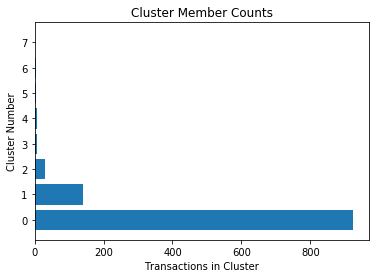

In [9]:
################################################################################################################l
#Barplot of member counts
print(Counter(model.labels_))
clustered_series = pd.Series(data=model.labels_.flatten())
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)

locs, labels = plt.xticks()
plt.yticks(np.arange(0,len(clustered_series.value_counts()), step=1))

plt.title('Cluster Member Counts')
plt.xlabel('Transactions in Cluster')
plt.ylabel('Cluster Number');
plt.show

In [13]:
cluster_group = clus_train.groupby('cluster_label').mean()
print(cluster_group)

                   pca_1      pca_2      pca_3      pca_4
cluster_label                                            
0              -0.404129   0.048255   0.048255   0.048255
1               7.843375   3.297487   3.297487   3.297487
2               6.431268  -4.398060  -4.398060  -4.398060
3              14.091218  15.895708  15.895708  15.895708
4               0.899508  -0.897069  -0.897069  -0.897069
5               0.915294   2.049791   2.049791   2.049791
6              15.786452  -9.694558  -9.694558  -9.694558
7               9.285150   7.056085   7.056085   7.056085


## TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1120 samples in 0.002s...
[t-SNE] Computed neighbors for 1120 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1120
[t-SNE] Computed conditional probabilities for sample 1120 / 1120
[t-SNE] Mean sigma: 0.000197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.444489
[t-SNE] Error after 300 iterations: 0.253019
t-SNE done! Time elapsed: 10.807117700576782 seconds


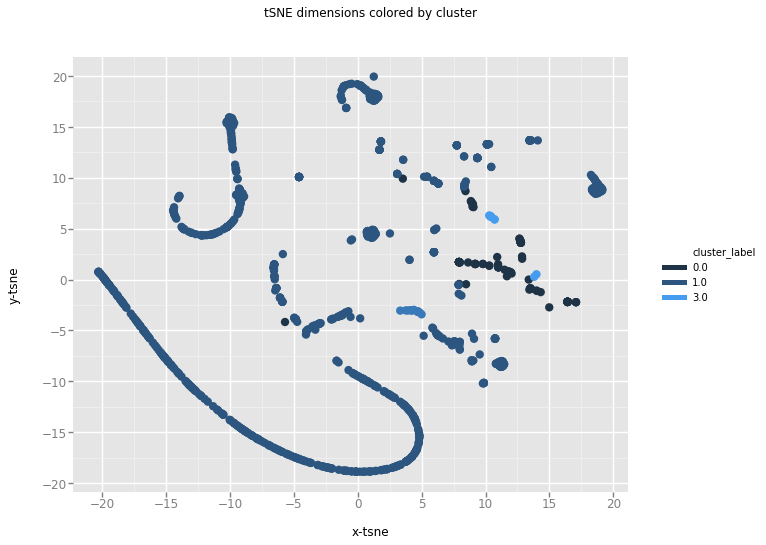

<ggplot: (8794167762205)>

In [9]:
feat_col=['num_unique_addr_in', 'total_val', 'num_unique_addr_out', 'ratio','degree']

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(clus_train.loc[:,feat_col])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_tsne = clus_train
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='cluster_label') ) \
        + geom_point(size=70,alpha=1) \
        + ggtitle("tSNE dimensions colored by cluster")
chart

## DBSCAN - Try OPTICS as well

In [ ]:
################################################################################################################l
#DBSCAN Clustering

clf = sklearn.cluster.DBSCAN(eps=1.9, min_samples=3)
clf.fit(clus_train)
labels = clf.labels_
print(Counter(labels))

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

ss = silhouette_score(clus_train, labels, metric='euclidean')
print("\nSilhouette Score: %f" % ss)

################################################################################################################l
#Principal Component Analysis

colors = ['red', 'blue', 'yellow','black']
pca_2 = sklearn.decomposition.PCA(2)
plot_columns = pca_2.fit_transform(clus_train)    
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1],c=labels,cmap = matplotlib.colors.ListedColormap(colors),edgecolors = 'none')
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 clusters')
plt.show

# Get cluster assignment labels
labels = model.labels_
# Format results as a DataFrame
data = {'transaction_id':clus_train.index,'cluster_label':labels}
results = pd.DataFrame(data)


# Determining statistics of inputs, outputs of a transaction

In [ ]:
tx_ids = []
tx_id_val = []
txo_in_ids = []
txo_out_ids = []
iadr = []
oadr = []
txi_ids = []


for val in df.iadr.value_counts().iteritems():
    iadr.append(val[0])

for val in df.id_txi.value_counts().iteritems():
    txi_ids.append(val[0])
    
    
for val in df.oadr.value_counts().iteritems():
    oadr.append(val[0])
    
for val in df.id_t.value_counts().iteritems():
    tx_ids.append(val[0])
    data = df[df.id_t==val[0]]
    tx_id_val.append(data.output_val.sum())
    

for val in df.id_txo_in.value_counts().iteritems():
    txo_in_ids.append(val[0])
    
for val in df.id_txo_out.value_counts().iteritems():
    txo_out_ids.append(val[0])

In [ ]:
print(len(txo_in_ids))
print(len(txi_ids))
print(len(tx_ids))
print(len(txo_out_ids))

In [ ]:
matches = set(txo_in_ids).intersection(txo_out_ids)
print(len(matches))

In [ ]:
print(len(iadr))
print(len(oadr))

In [ ]:
matches = set(iadr).intersection(oadr)
len(matches)